In [2]:
import numpy as np
import matplotlib.pyplot as plt 

import importlib

import components as comp
importlib.reload(comp);

import utils
importlib.reload(utils);

In [3]:
### Parameters
computational_states    = 3
resonator_states        = 10

# System
system = utils.System(dimensions = (resonator_states, computational_states))

# Define the components, which are defined in components.py
# The superconducting qubit
transmon = comp.Transmon(
    n_cutoff        = 11,
    e               = 1.519e6,              # GHz / V
    EJ              = 34,                   # GHz hbar
    EJ_EC_ratio     = 128,                  # Gives EC = EJ / ratio
    # gamma           = 2.5                 # EJ2 / EJ1    
)

# Resonator for readout
resonator = comp.Resonator(
    omega           = 6.02,                 # GHz
    n_cutoff        = resonator_states      # States of harmonic oscillator
    
)

# Readout pulse
readout_pulse = comp.ResonatorProbePulse(
    omega       = 6.02,
    duration    = (20, 30),
    rise_time   = 2,
    fall_time   = 2,
    amplitude   = 5 / 6.02 ** 2
)


## Defining Hamiltonians
We can now define the hamiltonians of the system:

In [24]:
# Find subspace of Transmon
Es, Psis = transmon.eigen_basis(computational_states)   # Get states and energies for transmon
H0_transmon = np.diag(Es - Es[0])                       # Set E0 = 0


# H0 of the resonator is simply found by:
H0_resonator    = resonator.Hamiltonian().todense()


# We need to define mathematical tools to combine the system
transmon_identity   = np.identity(n = computational_states)
resonator_identity  = np.identity(n = resonator_states)


# Combine the Hamiltonians by tensor product 
H0_transmon_big  = np.kron(resonator_identity,  H0_transmon)
H0_resonator_big = np.kron(H0_resonator,        transmon_identity)

# Sum to get full H0 in 3 x 20 space
H0 = H0_transmon_big + H0_resonator_big


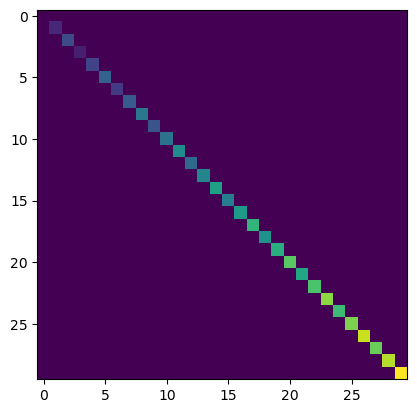

In [25]:
plt.imshow(H0)

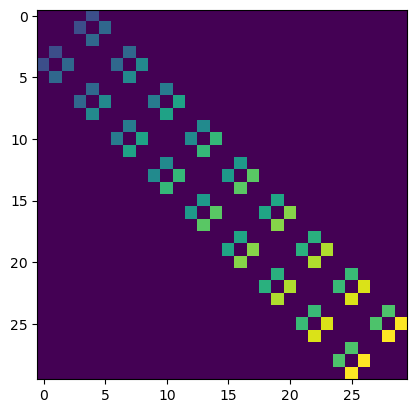

In [26]:
# Overlap
H_overlap_n = abs(np.conjugate(Psis).T @ transmon.n_matrix() @ Psis)

# # Lower qubit raise resontaor
# H_q_to_r = np.kron(resonator.a_dagger().todense(), np.tril(transmon_identity))
# H_r_to_q = np.kron(resonator.a().todense(),        np.triu(transmon_identity))


H_int = np.kron((resonator.a_dagger() + resonator.a()).todense(), H_overlap_n)


# Transmon interaction
# H_overlap_n = abs(np.conjugate(Psis).T @ transmon.n_matrix() @ Psis)

#### NEED MORE THEORY TO DEFINE THIS INTERACTION TERM #### 
# Now we just assume g_k = 1. Probably we take the overlap between them.
# H_int_resonator = (resonator.a_dagger() + resonator.a()).todense()

# Direct product to get it in 3 x 20 hilbert space
# H_int = np.kron(np.triu(H_int_resonator), np.tril(H_overlap_n)) + np.kron(np.tril(H_int_resonator), np.triu(H_overlap_n))


plt.imshow(H_int)

## Interaction Eigenvalues 

/tmp/ipykernel_344/1958045196.py:4: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(H_with_interaction))


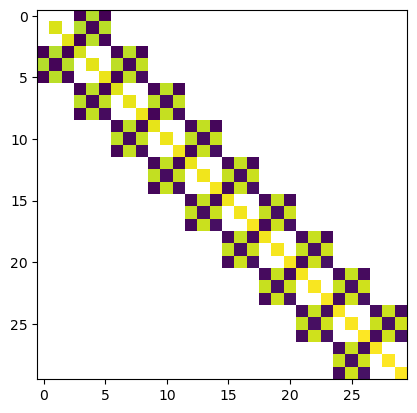

In [27]:
interaction_strength = .130 * 2 * np.pi # GHz 

H_with_interaction = H0 + interaction_strength *  H_int
plt.imshow(np.log(H_with_interaction))

## Readout Drive

In [32]:

# Define Hamilton with given frequency
def get_Hamiltonian(omega):
    # Define the resonator given a pulse frequency
    readout_pulse = comp.ResonatorProbePulse(
        omega       = omega,
        duration    = (0, 50),
        rise_time   = 2,
        fall_time   = 2,
        amplitude   = 1 / 10
    )

    # Get pulse and the Unitary transformation opposite to the pulse
    pulse_on_resonator = readout_pulse.output()
    U = readout_pulse.rotating_frame(dims = np.product(system.dimensions))

    def Hamiltonian(t):
        constant_H = H_with_interaction

        # Define the pules and hamiltonian interacting with the resonator
        total_pulse = pulse_on_resonator[0](t) + pulse_on_resonator[1](t) 
        H_reso      = 2j *  total_pulse * (resonator.a_dagger() - resonator.a())
        H_reso_hilbert_space = np.kron(H_reso.todense(), transmon_identity)

        return constant_H + H_reso_hilbert_space

    return Hamiltonian, U


def master_equation(t, y, hamiltonian, U):
    # Get the hamiltonian and the unitary transformation
    H = hamiltonian(t)
    U = U(t)

    H_rotating = H

    rho = y.reshape((system.dimensions[0] * system.dimensions[1], system.dimensions[0] * system.dimensions[1]))

    # Calculate the derivative of the density matrix
    d_rho = -1j * (H_rotating @ rho - rho @ H_rotating.conj().T)

    return d_rho.flatten()

In [33]:
# Define the first excited state of the resonator
resonator_g = np.zeros(resonator_states, dtype = np.complex128)
resonator_g[0] = 1

# Define ground state of transmon
transmon_g = np.array((1, 0, 0), dtype = np.complex128)
transmon_e = np.array((0, 1, 0), dtype = np.complex128)

# Define initial density matrix
initial_state_g = np.kron(resonator_g, transmon_g)
initial_density_matrix_g = np.outer(initial_state_g, initial_state_g.conj())

initial_state_e = np.kron(resonator_g, transmon_e)
initial_density_matrix_e = np.outer(initial_state_e, initial_state_e.conj())

In [34]:
from numba import prange
from tqdm import tqdm
from scipy.integrate import solve_ivp
from multiprocessing import Pool

# Define the frequencies to test
omegas_to_test = np.linspace(5.52, 6.52, 3)

# Duration of Simulation
duration = (0, 50)



def simulate(omegas, initial_state):
    results = []

    for i in tqdm(range(len(omegas_to_test))):
        omega = omegas_to_test[i]
        
        H, U = get_Hamiltonian(omega)
        
        sol = solve_ivp(master_equation, duration, initial_state.flatten(), args = (H, U), method = 'RK45')

        results.append(sol)

    return results

print("Simulating ground state")
results_g = simulate(omegas_to_test, initial_density_matrix_g)

print("Simulating excited state")
results_e = simulate(omegas_to_test, initial_density_matrix_e)

Simulating ground state


100%|██████████| 3/3 [00:26<00:00,  8.86s/it]


Simulating excited state


100%|██████████| 3/3 [00:28<00:00,  9.35s/it]


In [52]:
from scipy.special import factorial

def Q_function(density_matrix, n_cutoff = resonator_states, resolution = 20):
    xs = ys = np.linspace(-n_cutoff, n_cutoff, resolution)
    xs, ys = np.meshgrid(xs, ys)

    # Calculate alphas
    alphas = xs + 1j * ys
    alphas = alphas.flatten()

    # Noramlization
    normalization = np.exp(- alphas * alphas.conj() / 2)

    # Basis change
    ns = np.expand_dims(np.arange(n_cutoff), 1)
    U  = normalization * np.power(alphas, ns) / np.sqrt(factorial(ns))

    return np.diag(U.conj().T @ density_matrix @ U).reshape((resolution, resolution))


In [53]:
Q_function(last_reso_state).shape

(20, 20)

In [60]:
results_g[0].y.shape[-1]

2326

In [66]:
def plot_Q(time):
    results_e[1].y.shape

    states = results_g[0].y.reshape(system.hilbert_size, system.hilbert_size, -1)
    last_reso_state = system.partial_trace(states[:, :, time], 1)

    plt.imshow(abs(Q_function(last_reso_state, resolution = 100)))

from ipywidgets import interact
interact(plot_Q, time = (0, results_e[0].y.shape[-1] - 1, 1))

interactive(children=(IntSlider(value=1199, description='time', max=2399), Output()), _dom_classes=('widget-in…

<function __main__.plot_Q(time)>

In [67]:
def plot_Q(time):
    results_g[1].y.shape

    states = results_g[0].y.reshape(system.hilbert_size, system.hilbert_size, -1)
    last_reso_state = system.partial_trace(states[:, :, time], 1)

    plt.imshow(abs(Q_function(last_reso_state, resolution = 100)))

from ipywidgets import interact
interact(plot_Q, time = (0, results_e[0].y.shape[-1] - 1, 1))

interactive(children=(IntSlider(value=1199, description='time', max=2399), Output()), _dom_classes=('widget-in…

<function __main__.plot_Q(time)>

In [304]:
dims = np.prod(system.dimensions)
def get_expectation_occupation(results):
    rhos = [np.outer(ds.y[:, -1], ds.y[:, -1].conj) for ds in results]
    # last_rho = [rho[:, :, -1] for rho in rhos]
    last_rho_reso = [system.partial_trace(rho, trace_over = 1) for rho in rhos]
    last_exp_n    = [np.trace(rho @ resonator.n_matrix()) for rho in last_rho_reso]

    return last_exp_n

exp_n_g = get_expectation_occupation(results_g)
exp_n_e = get_expectation_occupation(results_e)


ValueError: x and y can be no greater than 2D, but have shapes (7,) and (7, 3, 3)

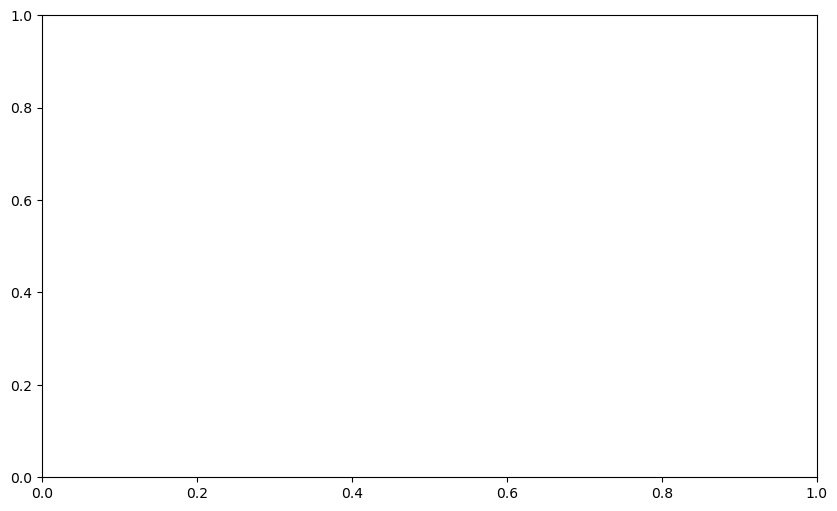

In [305]:
fig, ax = plt.subplots(figsize = (10, 6))

plt.plot(omegas_to_test, exp_n_e, marker = "x", label = "excited state")
plt.plot(omegas_to_test, exp_n_g, marker = "x", label = "ground state")

plt.legend()

In [ ]:

density_matrices = [results.y[:, i].reshape(dimensions) for i in range(len(results.t))]
density_matrices = np.array(density_matrices)

resonator_density_matrices = [system.partial_trace(density_matrices[i], 0) for i in range(len(results.t))]
resonator_density_matrices = np.array(resonator_density_matrices)


avg_photon_count = np.trace(np.expand_dims(resonator.n_matrix().todense(), 0) @ resonator_density_matrices, axis1 = 1, axis2 = 2)

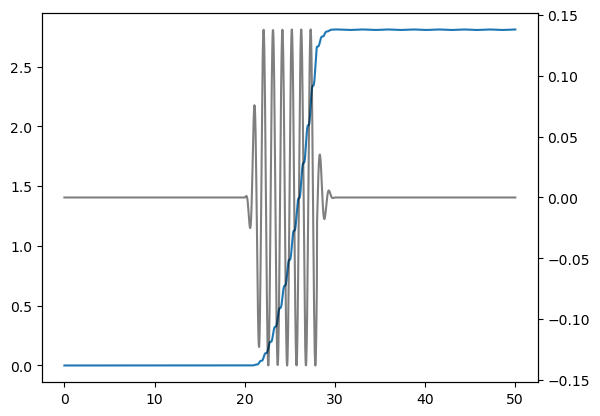

In [ ]:
fig, ax = plt.subplots()
ax.plot(results.t, avg_photon_count)
# plt.plot(results.t, np.imag(S11))

ax1 = ax.twinx()
ax1.plot(results.t, pulse_on_resonator[0](results.t) + pulse_on_resonator[1](results.t) , color = 'black', alpha = 0.5)
# ax1.set_ylim(-1.1, 5)